In [2]:
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
import re
import cftime
from datetime import datetime
from dask.diagnostics import ProgressBar
from scipy.stats import t
from scipy.stats import linregress
from eofs.xarray import Eof
from eofs.examples import example_data_path
import calendar
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from types import SimpleNamespace


In [9]:
class EnsembleMemberCalculations:
    def __init__(self, data_path: Path, model=None, member_id=None):
        #use self. to access attributes
        self.data_path = Path(data_path)
        
        #referencing the parent model and setting up shortcuts
        self.model = model
        self.experiment = model.experiment if model else None
        self.all_experiments = self.experiment.all_experiments if self.experiment else None

        if member_id is not None:
            #manually overriding the naming function - for adding observations in. - what is passed through as member_id
            self.member_id = member_id
        else:
            #extracting the member_id (ensemble number) from the filename as named in CMIP6 convention
            match = re.search(r"(r\d+i\d+p\d+f\d+)", self.data_path.stem)
            if not match:
                raise ValueError(f"Could not extract the member_id from filename: {self.data_path.name}")
            #selecting the ensemble number and assigning it to the member ID
            self.member_id = match.group(1)


        self.data = None

    def load_data(self):
        #loads the data of an ensemble member
        self.data = xr.open_dataset(self.data_path)

        #normalisation for the era5 dataset
        if self.model and self.model.name == "era5":
            self.normalise_era5()
            
        return self.data

    def normalise_era5(self):
        """
        Basically fix the coordinates lat/lon shift for era5
        Also rename msl - psl, latitude - lat and longitude - lon
        """

        ds = self.data

        #renaming msl to psl
        if "msl" in ds.variables and "psl" not in ds.variables:
            ds = ds.rename({"msl": "psl"})


        #change to lat/lon
        coord_map = {}
        if "latitude" in ds.dims:
            coord_map["latitude"] = "lat"
        if "longitude" in ds.dims:
            coord_map["longitude"] = "lon"
        if coord_map:
            ds = ds.rename(coord_map)

        #shift the lon from [0,...,360] to [-180,...,180]
        if (ds.lon > 180).any():
            new_lon = np.where(ds.lon > 179, ds.lon - 360, ds.lon)
            ds = ds.assign_coords(lon=new_lon)

            #Making sure they are sorted in ascending order
            sorted_lon = np.sort(ds.lon)
            ds = ds.sel(lon=sorted_lon)

        #Also ensure that lats are sorted in ascending order
        if ds.lat.values[0] > ds.lat.values[-1]:
            ds = ds.reindex(lat=list(reversed(ds.lat)))

        self.data = ds

    def get_calendar_type(self):
        if self.model is None:
            raise RuntimeError("Model is not set")
        return self.model.calendar_type

    def get_time_bounds(self):
        """
        Access the model's time_bounds - each model has a different calendar thus type of time to index/slice by
        """
        if self.model is None or self.model.time_bounds is None:
            raise RuntimeError("Model or time_bounds is not set")
        return self.model.time_bounds

    def select_data(self):
        """
        Just selecting some data from the time bounds in model
        """
        ds = self.load_data()
        start, end, delta, time_str = self.model.time_bounds
        ds = ds[self.all_experiments.varname].sel(time=slice(start, end))
        
        return ds

    def crop_to_domain_ensemble(self, da: xr.DataArray):
        """
        Crops the ensemble members data (anomaly, raw data etc.) to the lat and lon of the domain
        lat_bounds = (lat_min, lat_max)
        lon_bounds = (lon_min, lon_max)
        Assuming data of the format -180 to 180, -90 to 90???
        Will add another function to check and if not flag error
        Will be a bit for if model is era5 shift the coords at somepoint in the processing data stages.
        Need to already have selected the variable"""

        if self.all_experiments and self.all_experiments.lat_bounds and self.all_experiments.lon_bounds:
            da = da.sel(
                lat=slice(self.all_experiments.lat_bounds[0], self.all_experiments.lat_bounds[1]),
                lon = slice(self.all_experiments.lon_bounds[0], self.all_experiments.lon_bounds[1])
            )
        return da

    def calc_seas_anomaly(self):
        """
        Will calculate the seasonal anomaly
        """
        #print(self.model.name)
        output_file = self.all_experiments.output_dir / f"psl_anomalies/{self.experiment.name}/{self.model.name}/psl_mon_{self.experiment.name}_{self.model.name}_{self.member_id}_{self.all_experiments.season_str}_anomaly_{self.model.time_bounds[3]}.nc"
        
        if output_file.exists():
            print(f"Loading the exisiting file for the anomaly from: {output_file}")
            anomaly = xr.open_dataset(output_file)[self.all_experiments.varname]
            return self.crop_to_domain_ensemble(anomaly)

        
        print(f'Calculating the {self.all_experiments.season_str} anomaly for model {self.model.name}')

        #does load the CMIP6 data from the leader_epesc gws
        if self.data is None:
            self.load_data()
            
        ds = self.data[self.all_experiments.varname]
        start, end, delta, time_str = self.model.time_bounds
        ds = ds.sel(time=slice(start,end))

        months = self.all_experiments.season
        season = "".join([calendar.month_abbr[m][0] for m in months])

        #selecting the relevant months
        mask = ds['time'].dt.month.isin(months)
        months_in_seas = ds.sel(time=mask)
        
        #assign the 'season' year - wrapping round the change in year
        season_year = months_in_seas['time'].dt.year
        if months[0] > months[-1]:
            season_year = xr.where(
                months_in_seas['time'].dt.month >= months[0],
                season_year + 1,
                season_year,
            )

        months_in_seas = months_in_seas.assign_coords(year=season_year)

        #group by year
        ds_seas = months_in_seas.groupby('year').mean(dim='time')

        #find the climatology and subtract to get the seasonal anomaly
        clim = ds_seas.mean(dim='year')
        anomaly = ds_seas - clim

        #drop the last year if incomplete
        #if months[0] > months[-1]:
        #anomaly = anomaly.isel(year=slice(0,-1))

        anomaly.to_netcdf(output_file)
        return self.crop_to_domain_ensemble(anomaly)

    def calc_EOF_per_ensemble(self,max_modes: int):
        """
        Want to calculate the EOF for each ensmeble member per model per experiment
        Will do this by literally just using the psl_anomalies
        Will also check whether this data already exists or not.
        Will actually only feed historical into this.
        Bear in mind - I ahve not concatenated so will be year NOT time!
        """
        output_file_EOF = self.all_experiments.output_dir / f"EOF/{self.experiment.name}/{self.all_experiments.season_str}/{self.model.name}/psl_mon_{self.experiment.name}_{self.model.name}_{self.member_id}_{self.all_experiments.season_str}_EOF_indiv_{self.model.time_bounds[3]}.nc"
        #if output_file_EOF.exists():
        #    print(f"Loading the EOF for each ensemble member in model {self.model.name} and {self.experiment.name}")
        #    return xr.open_dataset(output_file_EOF)['eofs']

        print('calculating the EOF')
        #Now need to calculate the EOFs from the seasonal anomalies
        anomaly = self.calc_seas_anomaly()
        anomaly = anomaly.rename({'year': 'time'})
        anomaly = anomaly / 100
        anomaly_trans = anomaly.transpose('time', 'lat', 'lon')

        coslat = np.cos(np.deg2rad(anomaly_trans.coords['lat'].values)).clip(0., 1.)
        wgts = np.sqrt(coslat)[...,np.newaxis]

        solver = Eof(anomaly_trans, weights=wgts)
        EOF = solver.eofs(neofs=max_modes).sel(mode=([0,max_modes-1]))
        print(f'The fraction of variance explained in model {self.model.name} and member {self.member_id}: {solver.varianceFraction(neigs=2)*100}')
        EOF.to_netcdf(output_file_EOF)
    
        return EOF

#-------------------------------------------------------------------------------------------------------------------------------------------------------        

class ModelCalculations:
    def __init__(self, folder: Path, experiment, obs_path: Path = None, model_name: str = None, member_id: str = None):
        """
        Setting up the models
        Can also set up obs as a model
        """
        
        self.folder = Path(folder) if folder else None
        self.experiment = experiment
        self.all_experiments = self.experiment.all_experiments if self.experiment else None

        #can now set the model name using the folder name
        #the .name takes the last bit of the filepath (which in this case is the model)
        if model_name:
            self.name = model_name
        else:
            self.name = self.folder.name
        
        #creating my dictionary of ensemble members
        self.members = {}

        #adding in the observations as a special case
        if obs_path is not None:
            member = EnsembleMemberCalculations(obs_path, model=self, member_id=member_id or "ensemble1")
            self.members[member.member_id] = member
        else:
        #now for the normal CMIP6 model cases
            for i, file in enumerate(self.folder.glob("*.nc")):
                member = EnsembleMemberCalculations(file, model=self)
                self.members[member.member_id] = member
        
        #basically I pick the first member (load in just one)
        #doing this to then use to find the calendar type
        #and then find the time bounds as this will be the same time (correct datetime) per model
        member1 = next(iter(self.members.values()))
        member1.load_data()

        #find the calendar type
        time_var = member1.data["time"]
        self.calendar_type = type(time_var.time.values[0])
        self.time_bounds = None

    def set_time_bounds(self, start_year: int, end_year: int):
        #selecting the correct datetime format for the chosen time period
        if issubclass(self.calendar_type, cftime.DatetimeNoLeap):
            start = cftime.DatetimeNoLeap(start_year,1,16)
            end = cftime.DatetimeNoLeap(end_year,12,16)
        elif issubclass(self.calendar_type, cftime.Datetime360Day):
            start = cftime.Datetime360Day(start_year,1,16)
            end = cftime.Datetime360Day(end_year,12,16)
        else:
            start = datetime(start_year,1,16)
            end = datetime(end_year,12,16)

        #assumes that the last year is filled with data
        delta = end.year - start.year + 1
        time_str = f"{start_year}-{end_year}"
        self.time_bounds = (start, end, delta, time_str)
        return self.time_bounds

    def crop_to_domain_model(self, da: xr.DataArray):
        """
        Crops the ensemble members data (anomaly, raw data etc.) to the lat and lon of the domain
        lat_bounds = (lat_min, lat_max)
        lon_bounds = (lon_min, lon_max)
        Assuming data of the format -180 to 180, -90 to 90???
        Will add another function to check and if not flag error
        Will be a bit for if model is era5 shift the coords at somepoint in the processing data stages.
        Need to already have selected the variable"""

        if self.all_experiments and self.all_experiments.lat_bounds and self.all_experiments.lon_bounds:
            da = da.sel(
                lat=slice(self.all_experiments.lat_bounds[0], self.all_experiments.lat_bounds[1]),
                lon = slice(self.all_experiments.lon_bounds[0], self.all_experiments.lon_bounds[1])
            )
        return da

    def calc_ensemble_mean(self):
        """
        Calculate the SPATIAL ensemble mean for a variable
        Restrict it to the time bounds
        Could in future restrict to an area
        If the file exists load this instead
        """
        #selecting the time period
        start,end,delta,time_str = self.time_bounds

        output_file = self.all_experiments.output_dir / f"ens_mean_spat/{self.experiment.name}/{self.name}/{self.all_experiments.varname}_mon_{self.experiment.name}_{self.name}_spatial_EM.nc"
        print(output_file) 
        if output_file.exists():
            print(f"Loading the exisiting file for the spatial ensemble mean from: {output_file}")
            ens_mean = xr.open_dataset(output_file)[self.all_experiments.varname]
            return ens_mean
        
        #Get all the filepaths from the ensemble members
        #this line basically is getting the filepaths of the ensemble member class objects - i think?
        file_paths = [member.data_path for member in self.members.values()]
        print(file_paths)

        #then opening them all together
        ds = xr.open_mfdataset(
            file_paths,
            combine="nested",
            concat_dim="member",
            parallel=True,
            chunks={"member": 1}
        )[self.all_experiments.varname]

        ds = ds.sel(time=slice(start,end))

        #calculating the ensemble mean across the members
        ens_mean = ds.mean(dim="member")
    
        # Compute the result with a progress bar
        print(f"Computing the ensemble mean for {self.name}...")
        with ProgressBar():
            ens_mean.compute()#.to_netcdf(output_file)

        ens_mean.to_netcdf(output_file)
        print(f'Ensemble mean NOT saved to {output_file}')

        return ens_mean

    def calc_seasonal_mean_per_model(self):
        """
        Calculating the seasonal ensemble mean (could actually just be the seasonal mean for ay single file!!!)
        Only accpeting one file so per model
        Will save the seasonal mean as well as outputting it
        Wil crop to the already saved time periods.
        Will at some point make more versatille to choose the months of the year etc. as a list of int.
        """

        #select the time bounds and seasons
        start,end,delta,time_str = self.time_bounds
        months = self.all_experiments.season
        season = "".join([calendar.month_abbr[m][0] for m in months])
        
        seas_EM_output_file = self.all_experiments.output_dir / f"ens_mean_spat/{self.experiment.name}/{self.name}/psl_mon_{self.experiment.name}_{self.name}_spatial_{season}_EM_{time_str}.nc"
        print(seas_EM_output_file)
        if seas_EM_output_file.exists():
            print(f"Loading the seasonal mean for model: {self.name}")
            seasonal_mean = xr.open_dataset(seas_EM_output_file)[self.all_experiments.varname]
            return seasonal_mean

        #Now want a different pathway if era5 - no ensemble mean....
        if self.name.lower() == "era5":
            print("calculating directly from the single ensemble member")
            member = next(iter(self.members.values()))
            ds = member.data[self.all_experiments.varname]
            ds = ds.sel(time=slice(start,end))

        #for the model cases
        else:
            ds = self.calc_ensemble_mean()
            ds = ds.sel(time=slice(start,end))
            
        #creating mask for the season and grouping the months
        mask = ds['time'].dt.month.isin(months)
        months_in_seas = ds.sel(time=mask)

        #assigning a 'season year'
        season_year = months_in_seas['time'].dt.year

        #general code for if season WRAPS then fix the year to avg over
        if months[0] > months[-1]:
            season_year = xr.where(months_in_seas['time'].dt.month >= months[0],
                                  season_year +1,
                                  season_year)

        #assign as "year" instead of "season_year" for future bits
        months_in_seas = months_in_seas.assign_coords(year=season_year)
        
        #now groupby and average over the years
        ens_mean_seas = months_in_seas.groupby('year').mean(dim='time')
        ens_mean_seas.to_netcdf(seas_EM_output_file)

        print('calc seas_mean')
        
        return ens_mean_seas

    def calc_linear_trend_per_model(self):
        """
        Calcualte the linear trend from the seasonal ensemble mean
        Full stats file
        Converts from per unit time to just the change over the entire period (delta)
        And converts into hPa - so basically it is now hPa/delta."""
        #getting the timebounds
        start,end,delta,time_str = self.time_bounds
             
        #create and check if output_file exists
        output_file = self.all_experiments.output_dir / f"trend_calc_LESFMIP/linear_regression/NAO/{self.experiment.name}/{self.name}/psl_mon_{self.experiment.name}_{self.name}_{self.all_experiments.season_str}_linear_trend_stats_{time_str}.nc"

        if output_file.exists():
            print(f"loading the linear trend for model: {self.name}")
            return xr.open_dataset(output_file)
            
        #call the seasonal ensemble mean method
        seas_ens_mean = self.calc_seasonal_mean_per_model()
        print(seas_ens_mean)
    
        time = seas_ens_mean['year'].values
        lat = seas_ens_mean['lat'].values
        lon = seas_ens_mean['lon'].values
        time_numeric = np.arange(len(time))
    
        slope = np.full((len(lat), len(lon)), np.nan)
        intercept = np.full((len(lat), len(lon)), np.nan)
        p_value = np.full((len(lat), len(lon)), np.nan)
        stderr = np.full((len(lat), len(lon)), np.nan)

        #now solving for the slope and other stats (multiplying through by delta to convert from per index
        #(year) to change over the entire period)
        for i in range(len(lat)):
            for j in range(len(lon)):
                ts = seas_ens_mean[:, i, j].values / 100
                if np.all(np.isfinite(ts)):
                    reg = linregress(time_numeric, ts)
                    slope[i, j] = reg.slope * 165
                    intercept[i, j] = reg.intercept
                    p_value[i, j] = reg.pvalue
                    stderr[i, j] = reg.stderr * 165
    
        n = len(time_numeric)
        df = n - 2
        alpha = 0.05
        t_crit = t.ppf(1 - alpha/2, df)
    
        ci_lower = slope - t_crit * stderr
        ci_upper = slope + t_crit * stderr
    
        slope_da = xr.DataArray(slope, coords=[lat, lon], dims=["lat", "lon"], name="slope")
        intercept_da = xr.DataArray(intercept, coords=[lat, lon], dims=["lat", "lon"], name="intercept")
        p_value_da = xr.DataArray(p_value, coords=[lat, lon], dims=["lat", "lon"], name="p_value")
        ci_lower_da = xr.DataArray(ci_lower, coords=[lat, lon], dims=["lat", "lon"], name="slope_CI_lower")
        ci_upper_da = xr.DataArray(ci_upper, coords=[lat, lon], dims=["lat", "lon"], name="slope_CI_upper")
    
        # Save to one combined netCDF file
        trend_stats = xr.Dataset({
            "slope": slope_da,
            "intercept": intercept_da,
            "p_value": p_value_da,
            "slope_CI_lower": ci_lower_da,
            "slope_CI_upper": ci_upper_da
        })
        
        trend_stats.to_netcdf(output_file)
        return trend_stats

    def calc_seas_anomalies_all_members(self):
        """
        This will calculate the anomaly across the ensemble members
        Could maybe do this for all the other individual ensemble calcs needed to calc anomaly?
        Will return a dictionary {member_id: anomaly_dataarray}
        Only calculates for the historical??? - no need it for all!"""

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for member_id, member in self.members.items():
            print(member_id)
            anomaly = member.calc_seas_anomaly()
            results[member_id] = anomaly
        return results

    def calc_EOF_indiv_all_members(self, max_modes: int):
        """
        This will calculate the individual EOFs across one model
        Will basically output a range/spread of the EOFs for the models
        """

        results = {}
        for member_id, member in self.members.items():
            EOF_indiv = member.calc_EOF_per_ensemble(max_modes)
            results[member_id] = EOF_indiv
        return results

    def calc_EOF_mean(self, max_modes: int):
        """
        Calculate the mean of the indiviudally calculated EOFs for one model
        Will either load the data if it already exists or calls the methods needed to calculate it from the psl anomalies
        Hmmmmm I think I should try to use xr.open_mfdataset and hopefully can still use the spot check and then mean????
        Or maybe just calc_EOF_indiv_all_members???...
        """

        #selecting the time period
        start,end,delta,time_str = self.time_bounds
        #for member_id, member in self.members.items():
        #    output_file = self.all_experiments.output_dir / f"EOF/{self.experiment.name}/{self.all_experiments.season}/{self.name}/{self.all_experiments.varname}_mon_{self.experiment.name}_{self.name}_{member_id}_{self.all_experiments.season_str}_EOF_indiv_{time_str}.nc"
            #print(output_file)

        output_file = self.all_experiments.output_dir / f"EOF/historical/{self.all_experiments.season_str}/{self.name}/{self.all_experiments.varname}_mon_historical_{self.name}_{self.all_experiments.season_str}_EOF_mean_{time_str}.nc"
        if output_file.exists():
            print(f'loading the existing EOF model mean from: {output_file}')
            EOF_mean = xr.open_dataset(output_file)['eofs']
            return EOF_mean

        else:
            #all ensemble members across model
            print(f"Calculating the ensemble mean EOF across {self.name}")
            EOF_all_ens = self.calc_EOF_indiv_all_members(2)


            #will be filled so member_id - mode (a lat,lon EOF pattern)
            aligned_EOFs = {}

            #first member's key used to get member1
            member1 = list(EOF_all_ens.keys())[0]
            
            for member_id, member in EOF_all_ens.items():
                aligned_modes = []
            
                for n in range(0,max_modes):
                    #looping through each of the EOF modes
                    #selecting the first member as a reference
                    ref_EOF = EOF_all_ens[member1].isel(mode=n)
                    member_EOF = member.isel(mode=n)

                    #finding the dot product and aligning signs
                    dot_prod = (member_EOF * ref_EOF).sum().item()
                    
                    if dot_prod < 0:
                        aligned_modes.append(-member_EOF)
                    else:
                        aligned_modes.append(member_EOF)

                #stack aligned modes into a DataArray for a single member
                aligned_EOFs[member_id] = xr.concat(aligned_modes, dim='mode')


            EOFs_all_members = xr.concat(
                list(aligned_EOFs.values()),
                dim='member'
            )

            EOFs_all_members = EOFs_all_members.assign_coords(
                member=list(aligned_EOFs.keys())
            )

            EOFs_mean = EOFs_all_members.mean(dim='member')
            print(EOFs_mean, EOFs_mean.sel(mode=0))
                    
            EOFs_mean.to_netcdf(output_file)

        

    def calc_EOF_concat(self, max_modes: int):
        """
        Calculates the EOF from a concatenated list of anomalies for one model
        outputs the number of modes specified
        Calls on the anomalies calculated for each ensemble member
        This right now does all models not just historical - need an option for that somewhere???
        """
        output_file = self.all_experiments.output_dir / f"EOF/{self.experiment.name}/{self.all_experiments.season_str}/{self.name}/psl_mon_{self.experiment.name}_{self.name}_{self.all_experiments.season_str}_EOF_concat_{self.time_bounds[3]}.nc"
        output_file_reg = self.all_experiments.output_dir / f"EOF/{self.experiment.name}/{self.all_experiments.season_str}/{self.name}/psl_mon_{self.experiment.name}_{self.name}_{self.all_experiments.season_str}_reg_concat_{self.time_bounds[3]}.nc"

        if output_file.exists():
            #print(f"Loading the exisiting file for the EOF for: {output_file}")
            EOF = xr.open_dataset(output_file)['eofs']#['__xarray_dataarray_variable__']
            #EOF.sel(mode=0).plot()
            #plt.show()
            return EOF


        else:
            print('concatenating')
            #preprocess anomalies method called
            #converting from Pa to hPa - bear in mind I will need to have this as an option to convert.
            anomalies = {k: v / 100 for k, v in self.calc_seas_anomalies_all_members().items()}
            #anomalies = self.calc_seas_anomalies_all_members()
            
            anomaly_list = list(anomalies.values())
            anomaly_concat = xr.concat(anomaly_list, dim="ensemble")
            anomaly_2d = anomaly_concat.stack(time=('ensemble', 'year')).reset_index('time', drop=True)
            anomaly_trans = anomaly_2d.transpose('time', 'lat', 'lon')

            coslat = np.cos(np.deg2rad(anomaly_trans.coords['lat'].values)).clip(0., 1.)
            wgts = np.sqrt(coslat)[...,np.newaxis]

            solver = Eof(anomaly_trans, weights=wgts)
            EOF = solver.eofs(neofs=max_modes).sel(mode=([0,max_modes-1]))

            #checking orthogonality
            #1. Get the first two PCs (time series of each mode)
            pcs = solver.pcs(npcs=max_modes, pcscaling=0)  # shape (time, mode)
    
            # 2. Compute their correlation / covariance
            pc_corr = np.corrcoef(pcs[:, 0], pcs[:, 1])[0, 1]
            print("Correlation between PC1 and PC2:", pc_corr)

            # 3. (Optional) Gram matrix of PCs
            G = np.dot(pcs.T, pcs)  # shape (2,2)
            print("Gram matrix of PCs:\n", G)

            #Check orthogonality
            EOF1 = EOF.sel(mode=0)
            EOF2 = EOF.sel(mode=1)
    
            inner = (EOF1 * EOF2).sum(dim=("lat", "lon"))
            norm1 = np.sqrt((EOF1**2).sum(dim=("lat", "lon")))
            norm2 = np.sqrt((EOF2**2).sum(dim=("lat", "lon")))
            cos_sim = inner / (norm1 * norm2)
            is_ortho = bool(np.isclose(inner, 0, atol=1e-10))
            
            print(f"Inner product: {inner:.3e}, Cosine similarity: {cos_sim:.3e}")
            if not is_ortho:
                print("⚠️ Warning: EOF1 and EOF2 are not orthogonal within tolerance!")

            # --- Regression maps for all modes ---
            pcs_all = solver.pcs(npcs=max_modes, pcscaling=0)  # shape (time, max_modes)
            regression_maps = []
        
            for mode_idx in range(max_modes):
                pc = pcs_all[:, mode_idx]
                pc_da = xr.DataArray(pc, dims="time", coords={"time": anomaly_trans.coords["time"]})
                reg_map = (anomaly_trans * pc_da).mean(dim="time") / pc_da.var(dim="time")
                regression_maps.append(reg_map)
        
            # Combine into a single DataArray with a 'mode' dimension
            regression_map_all = xr.concat(regression_maps, dim=pd.Index(range(max_modes), name='mode'))
            regression_map_all.to_netcdf(output_file_reg)
            EOF.to_netcdf(output_file)
            
        return EOF

            
#-------------------------------------------------------------------------------------------------------------------------------------------------------

class ExperimentCalculations:
    def __init__(self, folder: Path, all_experiments):
        """
        Initialise an experiment object
        Each folder inside this experiment is a model
        """
        self.folder = Path(folder)
        
        #the experiment name (resturns the last part of the name!!!)
        self.name = self.folder.name
        self.all_experiments = all_experiments

        #this is the dictionary of ModelCalculations objects
        self.models = {}

        #going through all the sub folders within this experiment folder
        #The creating a ModelCalculations object for models folders
        for model_folder in self.folder.iterdir():
            if model_folder.is_dir():
                model_name = model_folder.name

                #skipping CNRM-CM6-1 for now
                if model_name == 'CNRM-CM6-1' or model_name == 'GISS-E2-1-G' or model_name=='NorESM2-LM':
                    continue
                    
                model = ModelCalculations(model_folder, experiment=self)
                self.models[model.name] = model

    def add_observations(self, obs_path: Path, model_name="era5", member_id="ensemble1"):
        """
        Add observations as a pseudo-model under this experiment.
        So I can add ERA5/other obs as one model, historical exp and one ensemble member"""
        
        obs_model = ModelCalculations(
            folder=None,
            experiment=self,
            obs_path=obs_path,
            model_name=model_name,
            member_id=member_id
        )

        self.models[obs_model.name] = obs_model
        
    def calc_ensemble_mean_all_models(self):
        """
        Calculate the ensemble mean for each model within this experiment
        Save results to an output dir
        """


        self.all_experiments.output_dir.mkdir(exist_ok=True, parents=True)

        results = {}
        for model_name, model in self.models.items():
            print(self.name)

            ens_mean = model.calc_ensemble_mean()
            results[model_name] = ens_mean

        return results
        
    def calc_seasonal_EM_all_models(self):
        """
        Calculate the ensemble mean for each model within this experiment
        Save results to an output dir
        """

        self.all_experiments.output_dir.mkdir(exist_ok=True, parents=True)

        results = {}
        for model_name, model in self.models.items():
            print(self.name)
            
            seas_ens_mean = model.calc_seasonal_mean_per_model()
            results[model_name] = seas_ens_mean

        return results

    def calc_linear_trend_all_models(self):
        """
        Calculate the linear trend from the seasonal ensemble mean
        Save results to an output dir
        """

        self.all_experiments.output_dir.mkdir(exist_ok=True, parents=True)

        print(self.name)
        results = {}
        for model_name, model in self.models.items():
            print(self.name)
            
            trend = model.calc_linear_trend_per_model()
            results[model_name] = trend

        return results


    def calc_seas_anomalies_all_models(self):
        """
        Calculate the anomalies across all ensemble members and models
        Will probably add in the steps that happen before - either call here or within calc_seas_anomaly
        returns a dict of dict: {model_name: {member_id: anomaly_dataset}}
        """

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)


        results = {}
        for model_name, model in self.models.items():
            model_results = model.calc_seas_anomalies_all_members()
            results[model_name] = model_results

        return results

    def calc_EOF_indiv_all_models(self, max_modes: int):
        """
        This will calculate the individual EOFs across one model
        Will basically output a range/spread of the EOFs for the models
        """

        results = {}
        for model_name, model in self.models.items():
            EOF_indiv_all_members = model.calc_EOF_indiv_all_members(max_modes)
            results[model_name] = EOF_indiv_all_members
        return results

    def calc_EOF_mean_all_models(self, max_modes: int):
        """
        Calculates the mean EOF (from the individual member EOFs) across all of the models
        """
        results = {}
        for model_name, model in self.models.items():
            EOF_mean = model.calc_EOF_mean(max_modes)
            results[model_name] = EOF_mean
        return results

    def calc_EOF_concat_all_models(self, max_modes: int):
        """
        To calculate the EOFs across all models
        """

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for model_name, model in self.models.items():
            model_results = model.calc_EOF_concat(max_modes)
            results[model_name] = model_results

        return results

    def projection_all_models(self, max_modes: int):
        """
        Project linear trend onto ALL modes for each model
        """
        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for model_name, model in self.models.items():
            proj = model.projection(max_modes)
            results[model_name] = proj

        return results
        
#-------------------------------------------------------------------------------------------------------------------------------------------------------

class AllDataComparisons:
    def __init__(self, folder: Path, output_dir: Path, obs_path: Path = None):
        """
        Initialise a comparisons object
        Will be used to comapre between all models and all experiments.
        Pass through the folder up to the experiments - will automatically sort for the experiment available
        """
        self.folder = Path(folder)
        self.output_dir = Path(output_dir)
        self.experiments = {}

        #going through all the sub folders within this experiment folder
        #The creating a ModelCalculations object for models folders
        for experiment_folder in self.folder.iterdir():
            if experiment_folder.is_dir():
                experiment = ExperimentCalculations(experiment_folder, all_experiments=self)
                self.experiments[experiment.name] = experiment

        if obs_path and "historical" in self.experiments:
            self.experiments["historical"].add_observations(obs_path, model_name="era5", member_id="ensemble1")
        #for the domain bounds
        self.lat_bounds = None
        self.lon_bounds = None

        self.season = None
        self.season_str = None
        self.varname = None

    def summary(self, show_members: bool = False):
        """
        Print a summary of the experiments, models, and optionally ensemble members.
        """
        print(f"\n📊 Summary of AllDataComparisons: '{self.folder.name}'")
        print(f"  Experiments loaded: {len(self.experiments)}")

        for exp_name, exp in self.experiments.items():
            print(f"  └── Experiment: {exp_name} ({len(exp.models)} models)")

            for model_name, model in exp.models.items():
                print(f"      └── Model: {model_name} ({len(model.members)} members)")

                if show_members:
                    for member_id, member in model.members.items():
                        print(f"          └── Member: {member_id}")
                        
            
    def set_time_bounds_all(self, start_year: int, end_year:int):
        """
        Set the time bounds for all the models in this experiment
        """

        for experiment in self.experiments.values():
            for model in experiment.models.values():
                model.set_time_bounds(start_year, end_year)

    def set_domain(self, lat_bounds: tuple, lon_bounds: tuple):
        """
        Defining the coordingates for the domain for cropping
        """

        self.lat_bounds = lat_bounds
        self.lon_bounds = lon_bounds
        print(self.lat_bounds, self.lon_bounds)

    def set_season(self, season: list[int]):
        """
        Sets the season - list like 12,1,2 is DJF
        """

        self.season = season
        self.season_str = "".join([calendar.month_abbr[m][0] for m in season])
        print(self.season_str,self.season)

    def set_variable(self, varname: str):
        """
        Setting the varibale to something like 'psl' or 'sst'
        Will at point need to add some sort of if statements to convert from Pa to hPa at the right stages.
        """

        self.varname = varname
        print(varname)

    def crop_to_domain_all_exp(self, da: xr.DataArray):
        """
        Crops to the lat and lon of the domain
        lat_bounds = (lat_min, lat_max)
        lon_bounds = (lon_min, lon_max)
        Assuming data of the format -180 to 180, -90 to 90???
        Will add another function to check and if not flag error
        Will be a bit for if model is era5 shift the coords at somepoint in the processing data stages.
        Need to already have selected the variable"""

        if self and self.lat_bounds and self.lon_bounds:
            da = da.sel(
                lat=slice(self.lat_bounds[0], self.lat_bounds[1]),
                lon = slice(self.lon_bounds[0], self.lon_bounds[1])
            )
        return da

    def add_sum_experiment(self):
        """
        Creating a 'sum' object-like thing to be added to the other experiments.
        New 'sum' in self.experiments - want it to flow well
        Tried adding like a sub-class but seemed to actually make it worse - can probably do better but don;t know how yet.
        So basically this calculates the sum and adds it but needs to add a bit so that when linear_trend_calc_per_model
        is called within the project_trend_EOF that it just returns the precomputed result.
        Might be worth seeing if there is a way to add sum after this so I don;t need to open files twice?...
        """

        sum_models = {}

        #getting all models names and looping through each model
        for model_name in self.get_all_model_names():
            model_trends = []

            #now getting the experiment names (that exist) and skipping the historical
            for exp_name, exp in self.experiments.items():
                if exp_name == 'historical':
                    continue

                #now selecting the models that exist for each experiment and then finding the linear trend
                #Getting all experiments in a list to sum later (for one model)
                if model_name in exp.models:
                    print(exp_name, model_name)
                    ds = exp.models[model_name].calc_linear_trend_per_model()
                    model_trends.append(ds['slope'])
                    if 'slope' not in ds:
                        print(f"{model_name} in {exp_name} has no slope")
                        continue                    

            if not model_trends:
                print(f"No trends found for {model_name}")
                continue

            # Align grids and sum slopes across all of the experiments for each model
            aligned = xr.align(*model_trends, join="outer")
            slope_sum = sum(a.fillna(0) for a in aligned)
            ds_sum = xr.Dataset({"slope": slope_sum})
            print(f"Slope sum for {model_name} computed")

            #This is basically a way to now save the sum for the models - I don;t get why I need the next bit???
            sum_models[model_name] = SimpleNamespace(
                name=model_name,
                calc_linear_trend_per_model=lambda ds=ds_sum: ds
            )
            
        # Now define a helper function for all models - Think this might be bad to do!!!!! - but like only need it here??? won;t use anywhere else but ewww.
        #basically calculates the linear trend for one model
        #this would be like for each experiment
        #
        def calc_linear_trend_all_models():
            return {m: mdl.calc_linear_trend_per_model()
                    for m, mdl in sum_models.items()}
            
        # Add new "synthetic" experiment - which is "sum" to the models.
        self.experiments["sum"] = SimpleNamespace(
            name="sum",
            models=sum_models,
            calc_linear_trend_all_models=calc_linear_trend_all_models
        )

        
    def project_trend_EOF(self, max_modes: int):
        """
        Projection of the linear trend onto the number of EOFs specified
        Will weight the trend to match the EOFs subspace (EOFs already weighted)
        If it already exists then can just upload the files
        Outputs:
            - Weighted linear trend
            - Projections for number of EOF modes specified
            - Residual (weighted linear trend - sum(projections))

        Returns the nested dict:
            experiment -> model -> xr.Dataset
            with variables: projection(projection_mode1, projection_mode2, ..., projection_modeN), residual, weighted_trend
        """
        delta = 165

        #1. adding 'sum' kinda like its own experimentcalc object - still don;t really understand how this works.
        self.add_sum_experiment()
        print(self.experiments.keys())

        #2. Calculate the historical EOF/read in from file if already calculated
        #this is basically selecting all models' EOFs for the historical and raising an error if not.
        if 'historical' in self.experiments:
            exp = self.experiments['historical']
            EOFs = exp.calc_EOF_concat_all_models(max_modes)
            #EOFs = exp.calc_EOF_mean_all_models(max_modes)
        else:
            raise ValueError(f"historical experiment has not been found")

        all_results = {}

        #3. Want to loop through all experiments (including sum) and get the linear trend for all models for this experiment.
        for experiment in self.experiments.values():
            all_results[experiment.name] = {}

            #now finding the trends for all models in this experiment
            trend_dict = {
                model_name: trend_ds
                for model_name, trend_ds in experiment.calc_linear_trend_all_models().items()
            }

            for model_name, trend_ds in trend_dict.items():
                eofs = EOFs[model_name]
                trend_var = trend_ds['slope']
                trend = self.crop_to_domain_all_exp(trend_var)

                #apply weights ONLY to the trend
                w = np.sqrt(np.cos(np.radians(trend['lat'])))
                w2d, _ = xr.broadcast(w, trend)
                trend_w2d = trend * w2d
    
                #stack the spatial dimensions (to solve the least squares)
                T = trend_w2d.stack(spatial=('lat', 'lon'))
                E = eofs.stack(spatial=('lat', 'lon')).transpose('spatial', 'mode')
    
                #now solve the least squares to get the coefficients, T (n_spatial,) E (n_spat, n_modes)
                T_vals = T.values
                E_vals = E.values
                c_vals, _, _, _ = np.linalg.lstsq(E_vals, T_vals, rcond=None)
                c = xr.DataArray(c_vals, dims=['mode'], coords={'mode': E.mode})


                #setting up so that there is a dict for projections
                projections = (c*eofs).transpose('mode', 'lat', 'lon')
                projections.name = "projection"

                #the total reconstrcution
                reconstructed = projections.sum(dim='mode')
                
                #finding the residual and adding it and the weighted trend to the nested dict
                residual = trend_w2d - reconstructed
                residual.name = "residual"

                #create the dataset
                proj_ds = xr.Dataset({
                    "projections": projections,
                    "residual": residual,
                    "weighted_trend": trend_w2d
                })

                #storing all the projections
                all_results[experiment.name][model_name] = proj_ds
                print('finished one models projection')
                
                
        return all_results

    def calc_R2(self, max_modes: int, all_results=None):

        if all_results is None:
            all_results = self.project_trend_EOF(max_modes)
        
        R2_vals = {}

        #remember this is like looping through objects so need to extract name via .name
        for experiment in self.experiments.values():
            R2_vals[experiment.name] = {}
            
            for model in experiment.models.values():
                ds = all_results[experiment.name][model.name]
                
                trend_w = ds['weighted_trend']
                residual = ds['residual']
                projections = ds['projections']

                total_var = (trend_w**2).sum().item()
                
                #creating R2 datastructure
                R2_vals[experiment.name][model.name] = {
                    "total": total_var,
                    "residual": float(( (residual**2).sum() / total_var).item()),
                    "projections": {}
                }

                for mode in projections.mode.values:
                    proj = projections.sel(mode=mode)
                    R2 = ( (proj**2).sum() / total_var ).item()
                    R2_vals[experiment.name][model.name]["projections"][int(mode)] = float(R2)

        return R2_vals

    def R2_plot(self, max_modes: int):
        """
        Creates the R2 plot across all the experiments and models
        """
        R2 = self.calc_R2(max_modes)
        print(R2)
        
        experiments = list(R2.keys())
    
        # Collect all unique models
        models = set()
        for exp_name in experiments:
            models.update(R2[exp_name].keys())
        models = sorted(models)
        
        # Marker styles for models
        marker_styles = ['o', 's', '^', '1', '3', 'P', '*', 'X', 'h', 'v', 'D']
        model_markers = {model: marker_styles[i % len(marker_styles)] for i, model in enumerate(models)}
        
        nrows = max_modes + 1  # weighted trend + projections + residual
        fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10, 4*nrows), sharex=True)
    
        # Row labels
        row_labels = [f'Mode {i}' for i in range(max_modes)] + ['Residual']

        handles, labels = [], []
        
        for i, row_label in enumerate(row_labels):
            ax = axes[i]
            for model in models:
                y_vals, x_vals = [], []
                for j, exp_name in enumerate(experiments):
                    if model not in R2[exp_name]:
                        continue  # skip missing experiment for this model
                    model_dict = R2[exp_name][model]
                    if i == nrows-1:
                        y_val = model_dict['residual']
                    else:
                        y_val = model_dict['projections'].get(i, np.nan)
                    y_vals.append(y_val)
                    x_vals.append(j)
                if y_vals:
                    sc = ax.scatter(x_vals, y_vals, marker=model_markers[model], s=100, label=model)
                    if i==0:
                        handles.append(sc)
                        labels.append(model)
            ax.set_ylabel("R²", fontsize=14)
            ax.set_title(row_label, fontsize=16)
    
        axes[-1].set_xticks(range(len(experiments)))
        axes[-1].set_xticklabels(experiments, rotation=45, ha='right', fontsize=12)
        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title="Models")

        fig.suptitle("R² for all models and experiments", fontsize=18)
        plt.tight_layout()
        plt.savefig('R2_all_models_and_exp.png')
        plt.show()

    def get_experiments_per_model(self, model:str):
        """
        Returns the dictionary of all experiments for a given model
        Take the model name in and returns dictionary
        """
        return {exp_name: exp_obj.models[model]
            for exp_name, exp_obj in self.experiments.items()
                if model in exp_obj.models
               }

    def get_all_model_names(self) -> list[str]:
        """
        Returns a list of models (list[str)]) across all experiments
        """
        model_names = ({
            model_name
            for exp_obj in self.experiments.values()
            for model_name in exp_obj.models.keys()
        })
        return sorted(model_names)

    def get_all_exp_names(self) -> list[str]:
        """
        Returns a list of models (list[str)]) across all experiments
        """
        exp_names = ({
            exp_name
            for exp_name in self.experiments.keys()
        })
        return sorted(exp_names)
                
    def projection_steps_plot(self, max_modes: int):
        """
        Create the projection plot basically plots the following for each model and experiment
        - weighted trend
        - bit explained by each mode
        - the residual
        currently manually setting the max and min - could be good to have a speerate method doing this?...
        """

        #getting the data from all models and experiments (the maps and the R2 values)
        all_results = self.project_trend_EOF(max_modes)
        R2 = self.calc_R2(max_modes, all_results=all_results)
        
        cmap='seismic'
        norm_all = mcolors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
        levels = np.arange(-4,4.1,0.1)
        lon_min, lon_max = self.lon_bounds
        lat_min, lat_max = self.lat_bounds

        #okay so getting the list of all model names across all experiments.
        #then finding the names/keys for the experimetns in the model
        #then plotting if they exist of do the missing step if not.
        
        exp_names = self.get_all_exp_names()
        
        for model_name in self.get_all_model_names():
            fig, ax = plt.subplots(
                nrows=max_modes + 2,
                ncols=len(exp_names),
                figsize=(28,15),
                subplot_kw={"projection": ccrs.PlateCarree()}
            )
            
            for j, exp_name in enumerate(self.get_all_exp_names()):
                try:
                    ds = all_results[exp_name][model_name]
                    R2_vals = R2[exp_name][model_name]

                    #getting the min and max of the weighted trend.
                    wt_min = float(ds['weighted_trend'].min())
                    wt_max = float(ds['weighted_trend'].max())
                    print(f"{model_name} - {exp_name} - weighted_trend: min={wt_min:.2f}, max={wt_max:.2f}")

                    #plotting the weighted trend if this experiment exists for the model
                    contour = ax[0,j].contourf(ds['lon'], ds['lat'], ds['weighted_trend'],
                        cmap=cmap, norm=norm_all,
                        levels=levels, transform=ccrs.PlateCarree()
                    )
                    ax[0,j].set_title(f"{exp_name}\n", fontsize=30)

                    #projection rows1...rown
                    for i, mode in enumerate(range(max_modes), start=1):
                        ds["projections"].sel(mode=mode).plot.contourf(
                            ax=ax[i, j],
                            cmap=cmap, norm=norm_all,
                            levels=levels, transform=ccrs.PlateCarree(),
                            add_colorbar=False
                        )
                        ax[i,j].set_title("")
                        ax[i,j].text(0.5, -0.05, f"r² = {R2_vals['projections'][i-1]:.2f}", transform=ax[i, j].transAxes, ha='center', va='top', fontsize=28)
                    
                    #residual (last row)
                    ds["residual"].plot.contourf(
                        ax=ax[max_modes + 1, j], cmap=cmap, norm=norm_all,
                        levels=levels, transform=ccrs.PlateCarree(),
                        add_colorbar=False
                    )
                    ax[3,j].text(0.5, -0.05, f"r² = {R2_vals['residual']:.2f}", transform=ax[3, j].transAxes, ha='center', va='top', fontsize=28)
                    ax[3,j].set_title("")
                        
                except KeyError:
                #if the experiment is missing
                    for i in range(max_modes + 2):
                        ax[i,j].set_title(f"{exp_name}")
                        ax[i,j].text(
                            0.5,0.5, "Missing",
                            ha="center", va="center",
                            fontsize=28, color="gray", transform=ax[i,j].transAxes
                        )
                        ax[i,j].set_xticks([])
                        ax[i,j].set_yticks([])
                        ax[i,j].coastlines
                # Add coastlines and formatting
                for i in range(4):
                    ax[i, j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
                    ax[i, j].add_feature(cfeature.COASTLINE, linewidth=1)
                    #ax[i, j].set_xlabel('lon', fontsize=28)
                    #ax[i, j].set_ylabel('lat', fontsize=28)
                    ax[i, j].set_aspect('auto')
                    if i == 0:
                        ax[0,j].set_title(f"{exp_name}\n", fontsize=30)
                    else:
                        ax[i,j].set_title("")
                    
                # Add colorbar
            ticks = [-4,-3,-2,-1,0,1,2,3,4]

            cax = fig.add_axes([0.92, 0.08, 0.015, 0.8])
            cbar = fig.colorbar(contour, cax=cax, orientation='vertical', ticks=ticks)
            cbar.set_label('MSLP (hPa)', fontsize=32)
            cbar.ax.tick_params(labelsize=30)

            # add y-axis labels only on the leftmost column
            #setting up the row labels
            row_labels = ["Weighted trend"] + [f"Mode {m}" for m in range(max_modes)] + ["Residual"]
            # Add row labels along the left-hand side using fig.text
            for i, label in enumerate(row_labels):
                # y coordinate is relative to the whole figure
                # compute vertical position from row index
                y = (ax[i, 0].get_position().y0 + ax[i, 0].get_position().y1) / 2
                fig.text(
                    0.1, y, label,
                    va="center", ha="center", rotation=90, fontsize=30
                )
        
            fig.suptitle(f"Projection steps for {model_name}", x=0.45, fontsize=32)
            plt.tight_layout
            for file_type in ['png','svg']:
                plt.savefig(f"Figures/Projection_plots_per_model/{file_type}/Projection_{model_name}.{file_type}", bbox_inches='tight')

                

In [10]:
all_data = AllDataComparisons(
    folder=Path("/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/"),
    output_dir=Path("/gws/nopw/j04/extant/users/slbennie/"),
    obs_path=Path("/gws/nopw/j04/leader_epesc/era5/era5.194001-202406.nc")
)

all_data.set_time_bounds_all(1940, 2014)
all_data.set_domain(lat_bounds=(20,80), lon_bounds=(-90,40))
all_data.set_season([12,1,2])
all_data.set_variable('psl')
era5 = all_data.experiments["historical"].models["era5"].members["ensemble1"]
Had = all_data.experiments["historical"].models["HadGEM3-GC31-LL"].members["r11i1p1f3"]

era5.calc_EOF_per_ensemble(2)
Had.calc_EOF_per_ensemble(2)

#era5_member = era5.members["ensemble1"]
#era5_member.select_data()

#historical = all_data.experiments['historical'].calc_EOF_concat_all_models(2)
#historical_EOFs = all_data.experiments['historical'].calc_EOF_indiv_all_models(2)
#historical_EOFs = all_data.experiments['historical'].calc_EOF_mean_all_models(2)
#all_data.experiments['historical'].models['HadGEM3-GC31-LL'].calc_seas_anomalies_all_members('psl')

# Access just like any other model
#era5 = all_data.experiments["historical"].models["era5"]
#era5_member = era5.members["ensemble1"]
#era5_member.calc_EOF_per_ensemble('psl',2)
#all_data.projection_steps_plot(2)
#all_data.R2_plot(2)
#era5_member.calc_seas_anomaly(Path('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/era5/psl_mon_historical_era5_ensemble1_DJF_anomaly.nc'),'psl')

(20, 80) (-90, 40)
DJF [12, 1, 2]
psl
calculating the EOF
Loading the exisiting file for the anomaly from: /gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/era5/psl_mon_historical_era5_ensemble1_DJF_anomaly_1940-2014.nc
The fraction of variance explained in model era5 and member ensemble1: <xarray.DataArray 'variance_fractions' (mode: 2)> Size: 16B
array([47.40927437, 16.43933489])
Coordinates:
  * mode     (mode) int64 16B 0 1
calculating the EOF
Loading the exisiting file for the anomaly from: /gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_DJF_anomaly_1940-2014.nc
The fraction of variance explained in model HadGEM3-GC31-LL and member r11i1p1f3: <xarray.DataArray 'variance_fractions' (mode: 2)> Size: 16B
array([42.86473144, 19.49920134])
Coordinates:
  * mode     (mode) int64 16B 0 1


PermissionError: [Errno 13] Permission denied: '/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_DJF_EOF_indiv_1940-2014.nc'

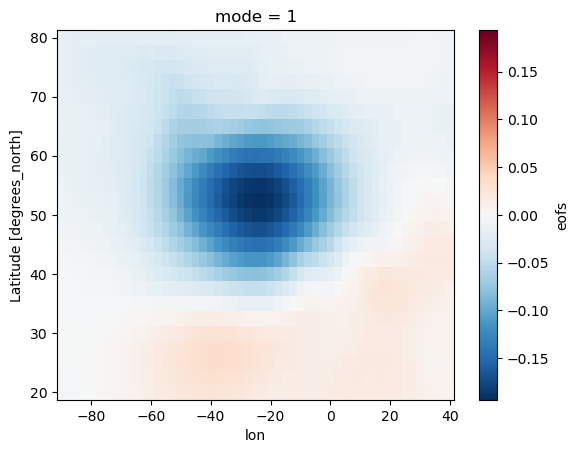

In [4]:
HadGEM3_mean = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_mean_1850-2014.nc')
HadGEM3_mean = HadGEM3_mean['eofs'].sel(mode=1)*-1
HadGEM3_concat = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_concat_1850-2014.nc')
HadGEM3_concat = HadGEM3_concat['eofs'].sel(mode=1)
HadGEM3_diff = HadGEM3_concat - HadGEM3_mean
HadGEM3_diff.plot()

-0.1237787815071517 0.10746196369002825


/tmp/ipykernel_587/1011441956.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


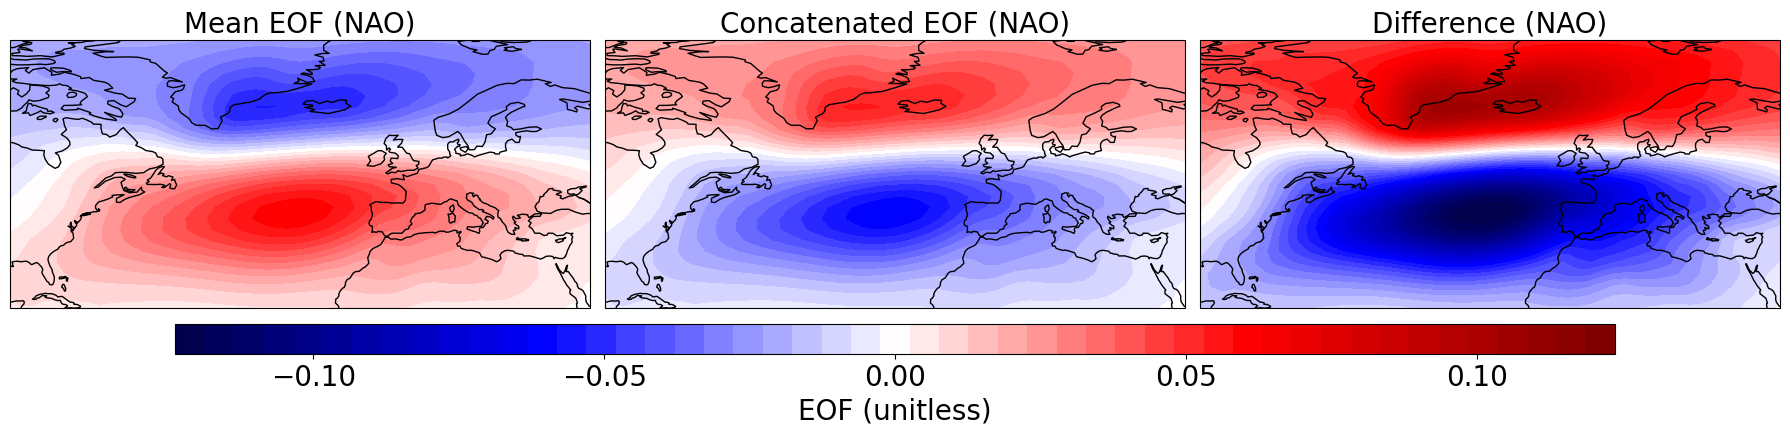

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr

# load data
HadGEM3_mean = xr.open_dataset(
    '/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_mean_1850-2014.nc'
)['eofs'].sel(mode=0) * -1

HadGEM3_concat = xr.open_dataset(
    '/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_concat_1850-2014.nc'
)['eofs'].sel(mode=0)

HadGEM3_diff = HadGEM3_concat - HadGEM3_mean

# pick consistent levels/norm
vmin = min(float(HadGEM3_mean.min()), float(HadGEM3_concat.min()), float(HadGEM3_diff.min()))
vmax = max(float(HadGEM3_mean.max()), float(HadGEM3_concat.max()), float(HadGEM3_diff.max()))
levels = np.linspace(vmin, -vmin, 50)
print(vmin,vmax)
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=-vmin)

# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})

HadGEM3_mean.plot.contourf(
    ax=axes[0], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[0].set_title("Mean EOF (NAO)", fontsize=20)
axes[0].coastlines()

HadGEM3_concat.plot.contourf(
    ax=axes[1], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[1].set_title("Concatenated EOF (NAO)", fontsize=20)
axes[1].coastlines()

im = HadGEM3_diff.plot.contourf(
    ax=axes[2], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[2].set_title("Difference (NAO)", fontsize=20)
axes[2].coastlines()

# shared colorbar
ticks = [-0.1, -0.05, 0, 0.05, 0.1]
cax = fig.add_axes([0.1, 0.2, 0.8, 0.05])
cbar = fig.colorbar(im, cax=cax, orientation="horizontal", fraction=0.05, pad=0.1, ticks=ticks)
cbar.set_label("EOF (unitless)", fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()


0.05945503956670898


/tmp/ipykernel_590/797854662.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


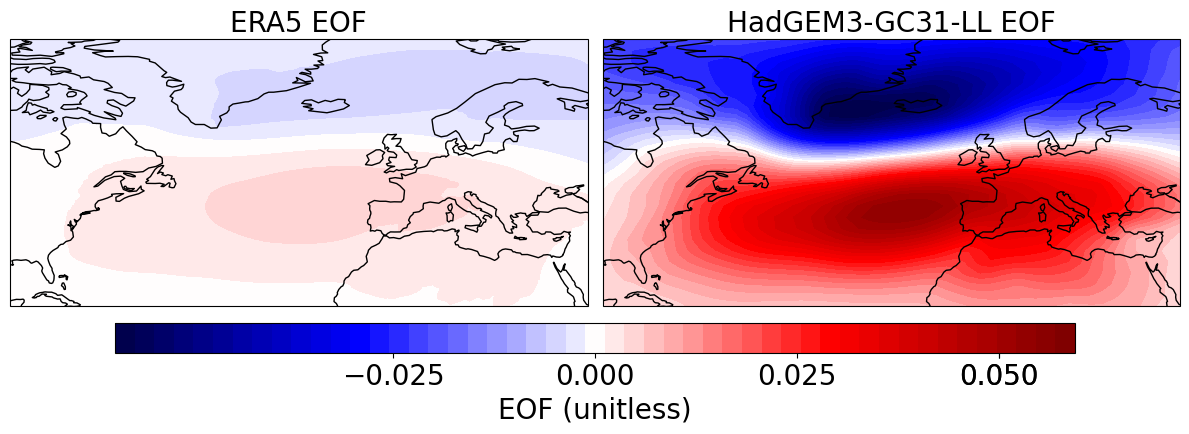

In [18]:
#era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/era5/psl_mon_historical_era5_ensemble1_DJF_EOF_indiv_1850-2014.nc')
#era5['eofs'].sel(mode=0).plot()
#plt.show()
era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/era5/psl_mon_historical_era5_ensemble1_DJF_EOF_indiv_1940-2014.nc')
era5 = era5['eofs'].sel(mode=0)

model = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_DJF_EOF_indiv_1940-2014.nc')
Had = (-1*model['eofs'].sel(mode=0))

# pick consistent levels/norm
vmin = min(float(Had.min()), float(era5.min()))
vmax = max(float(Had.max()), float(era5.max()))
maximum = max(-vmin,vmax)
levels = np.linspace(-maximum, maximum, 50)
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-maximum, vmax=maximum)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

era5.plot.contourf(
    ax=axes[0], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[0].set_title("ERA5 EOF", fontsize=20)
axes[0].coastlines()


im = Had.plot.contourf(
    ax=axes[1], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[1].set_title("HadGEM3-GC31-LL EOF", fontsize=20)
axes[1].coastlines()
print(maximum)

# shared colorbar
ticks = [0.05,-0.025,0,0.025,0.05]
cax = fig.add_axes([0.1, 0.2, 0.8, 0.05])

cbar = fig.colorbar(im, cax=cax, orientation="horizontal", fraction=0.05, pad=0.1, ticks=ticks)
cbar.set_label("EOF (unitless)", fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()

13.117533406816365


/tmp/ipykernel_587/2463312324.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


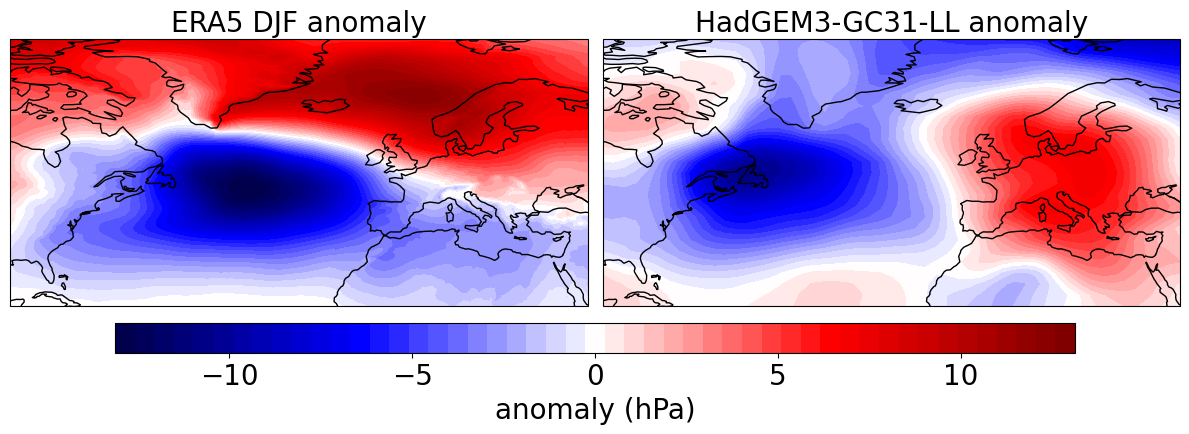

In [41]:
era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/era5/psl_mon_historical_era5_ensemble1_DJF_anomaly_1850-2014.nc')
era5 = era5['psl'].isel(year=0).sel(lat=slice(20,80), lon=slice(-90,40)) / 100
Had = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_DJF_anomaly_1850-2014.nc')
Had = Had['psl'].isel(year=0).sel(lat=slice(20,80), lon=slice(-90,40)) / 100


# pick consistent levels/norm
vmin = min(float(Had.min()), float(era5.min()))
vmax = max(float(Had.max()), float(era5.max()))
maximum = max(-vmin,vmax)
levels = np.linspace(-maximum, maximum, 50)
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-maximum, vmax=maximum)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

era5.plot.contourf(
    ax=axes[0], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[0].set_title("ERA5 DJF anomaly", fontsize=20)
axes[0].coastlines()


im = Had.plot.contourf(
    ax=axes[1], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[1].set_title("HadGEM3-GC31-LL anomaly", fontsize=20)
axes[1].coastlines()
print(maximum)
# shared colorbar
ticks = [-15,-10,-5,0,5,10,15]
cax = fig.add_axes([0.1, 0.2, 0.8, 0.05])

cbar = fig.colorbar(im, cax=cax, orientation="horizontal", fraction=0.05, pad=0.1, ticks=ticks)
cbar.set_label("anomaly (hPa)", fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()



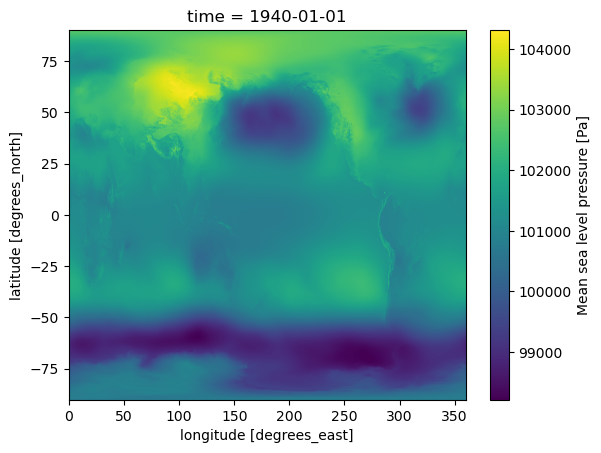

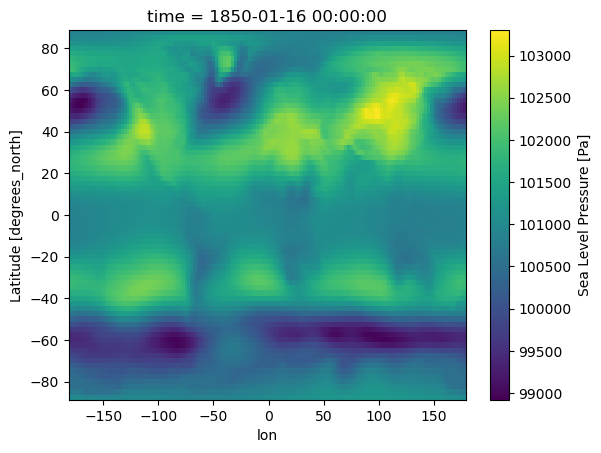

In [19]:
era5_og = xr.open_dataset("/gws/nopw/j04/leader_epesc/era5/era5.194001-202406.nc")
era5_og['msl'].isel(time=0).plot()
plt.show()

Had_og = xr.open_dataset("/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_interp.nc")
Had_og['psl'].isel(time=0).plot()

In [40]:
all_data = AllDataComparisons(Path("/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/"),
                              Path("/gws/nopw/j04/extant/users/slbennie/")
)

#all_data.summary()
all_data.set_time_bounds_all(1850, 2014)
all_data.set_domain(lat_bounds=(20,80), lon_bounds=(-90,40))
all_data.set_season([12,1,2])
#all_data.experiments['historical'].models['HadGEM3-GC31-LL'].calc_seas_anomalies_all_members('psl')

#all_results = all_data.calc_R2('psl', 2)
#R2 = all_results['historical']['HadGEM3-GC31-LL']
#all_data.project_trend_EOF("psl",2)
#all_data.calc_R2("psl",2)
#all_data.projection_steps_plot("psl",2)

#print(R2)
#exp_name_CanESM5 = all_data.get_experiments_per_model('CanESM5')

#print(exp_name_CanESM5)
#all_results = all_data.project_trend_EOF('psl',2)
#all_data.R2_plot(all_results,2)
all_data.projection_steps_plot('psl',2)
#all_data.add_sum_experiment('psl')

#print(all_data.experiments['sum'])

#all_data.projection_steps_plot('psl', 2)
#all_data.R2_plot('psl',2)
#historical = all_data.experiments['historical']
#EOF = historical.calc_EOF_concat_all_models(
#                    varname='psl',
#                    max_modes=2
#)

(20, 80) (-90, 40)
[12, 1, 2]
hist-GHG ACCESS-ESM1-5
loading the linear trend for model: ACCESS-ESM1-5
hist-aer ACCESS-ESM1-5
loading the linear trend for model: ACCESS-ESM1-5
hist-sol ACCESS-ESM1-5
loading the linear trend for model: ACCESS-ESM1-5
hist-volc ACCESS-ESM1-5
loading the linear trend for model: ACCESS-ESM1-5
Slope sum for ACCESS-ESM1-5 computed
hist-GHG CMCC-CM2-SR5
loading the linear trend for model: CMCC-CM2-SR5
hist-aer CMCC-CM2-SR5
loading the linear trend for model: CMCC-CM2-SR5
hist-volc CMCC-CM2-SR5
loading the linear trend for model: CMCC-CM2-SR5
Slope sum for CMCC-CM2-SR5 computed
hist-GHG CanESM5
loading the linear trend for model: CanESM5
hist-aer CanESM5
loading the linear trend for model: CanESM5
hist-sol CanESM5
loading the linear trend for model: CanESM5
hist-totalO3 CanESM5
loading the linear trend for model: CanESM5
hist-volc CanESM5
loading the linear trend for model: CanESM5
Slope sum for CanESM5 computed
hist-GHG FGOALS-g3
loading the linear trend for m

KeyboardInterrupt: 

In [31]:
ds = xr.open_dataset('/gws/nopw/j04/leader_epesc/era5/era5.194001-202406.nc')
print(ds['msl'])
ds = xr.open_dataset('/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_interp.nc')
print(ds['psl'])


<xarray.DataArray 'msl' (time: 1014, latitude: 721, longitude: 1440)> Size: 8GB
[1052775360 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2024-06-01
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Mean sea level pressure
    units:          Pa
<xarray.DataArray 'psl' (time: 1980, lat: 71, lon: 144)> Size: 162MB
[20243520 values with dtype=float64]
Coordinates:
  * time     (time) object 16kB 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lat      (lat) float64 568B -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon      (lon) float64 1kB -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Sea Level Pressure
    comment:        Sea Level Pressure
    uni